In [1]:
import pandas as pd
import data_selection

dfData = data_selection.getNotebookOutput()
dfData = dfData.loc[:, ~dfData.columns.str.contains("^Unnamed")]

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(dfData.dtypes)

subject_id                     int64
hadm_id                        int64
stay_id                        int64
akd                             bool
dka_type                       int64
macroangiopathy                 bool
microangiopathy                 bool
age                            int64
gender                        object
race                          object
weight                       float64
mechanical_ventilation          bool
use_crrt                        bool
use_NaHCO3                      bool
wbc                          float64
hb                           float64
plt                          float64
ag                           float64
bicarbonate                  float64
bun                          float64
calcium                      float64
scr                          float64
bg                           float64
phosphate                    float64
egfr                         float64
gcs                          float64
oasis                        float64
s

In [2]:
sum(dfData["akd"])/ len(dfData)

0.3933884297520661

In [3]:
droppingColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = ["dka_type", "gender", "race", "liver_disease", "ckd_stage"]
labelColumn = "akd"
numericColumns = [
    col
    for col in dfData.columns
    if col not in droppingColumns + categoryColumns + [labelColumn]
    and dfData[col].dtype != "bool"
]

In [37]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import auc, precision_score, recall_score, roc_curve, accuracy_score
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve( # type: ignore
        estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


def plot_calibration_curve(estimator, X, y):
    prob_pos = estimator.predict_proba(X)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y, prob_pos, n_bins=10
    )

    plt.figure(figsize=(10, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


def classification_metric_evaluate(model, X, y, binary=True, Threshold=None):
    # Predict probabilities
    y_pred_proba = model.predict_proba(X)[:, 1]

    # For simplicity, let's assume the threshold is 0.5 if not provided
    if Threshold is None:
        Threshold = 0.5

    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= Threshold).astype(int)

    # Calculate evaluation metrics
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    # Calculate confidence intervals for AUC
    from scipy import stats

    auc_values = np.array([auc for _, auc in sorted(zip(tpr, fpr))])  # Sort AUC values
    auc_l, auc_u = stats.t.interval(
        0.95, len(auc_values) - 1, loc=np.mean(auc_values), scale=stats.sem(auc_values)
    )

    # Construct dictionary to store evaluation metrics
    metric_dic = {
        "AUC": roc_auc,
        "AUC_L": auc_l,
        "AUC_U": auc_u,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "cutoff": Threshold,  # Include the threshold in the dictionary
    }

    # Return evaluation metrics and ROC curve points
    return fpr, tpr, metric_dic, y_pred

# Encode data

In [4]:
# Drop the first 3 columns (ids)
df = dfData.drop(columns=droppingColumns)

# Encode categorical variables
df = pd.get_dummies(df, columns=categoryColumns)

# Split train-test

In [6]:
from sklearn.model_selection import train_test_split


# Split data into features (X) and target variable (y)
X = df.drop(columns=["akd"])
y = df["akd"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Fill missing values

In [5]:
import pandas as pd
from sklearn.impute import KNNImputer


# fill missing value by k-nearest neighbors
imputer = KNNImputer(n_neighbors=5, weights="distance").fit(X_train)

X_train_filled = pd.DataFrame(imputer.transform(X_train), columns=(X_train.columns))
X_test_filled = pd.DataFrame(imputer.transform(X_test), columns=(X_test.columns))


,akd,macroangiopathy,microangiopathy,age,weight,mechanical_ventilation,use_crrt,use_NaHCO3,wbc,hb,...,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,liver_disease_MILD,liver_disease_NONE,liver_disease_SEVERE,ckd_stage_0.0,ckd_stage_1.0,ckd_stage_2.0,ckd_stage_3.0,ckd_stage_4.0
0,False,False,True,64.0,55.6,False,False,False,16.50,10.88,...,False,False,False,True,False,True,False,False,False,False
1,False,False,False,39.0,65.8,False,False,False,21.50,12.80,...,False,False,False,True,False,False,False,False,False,False
2,False,False,True,65.0,74.5,False,False,False,11.70,10.20,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,83.0,54.2,False,False,False,7.00,6.60,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,23.0,58.8,False,False,False,22.90,13.80,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,True,True,True,64.0,81.7,False,False,False,8.60,10.80,...,False,False,False,True,False,False,False,False,False,False
1206,False,True,True,76.0,74.0,False,False,False,12.90,10.00,...,False,False,False,True,False,False,False,False,False,True
1207,False,False,True,54.0,68.7,False,False,False,2.30,10.40,...,False,False,False,False,True,False,False,False,False,False
1208,True,False,False,56.0,117.8,False,False,False,8.90,14.80,...,False,False,False,True,False,False,False,False,False,False


# Plot curves 

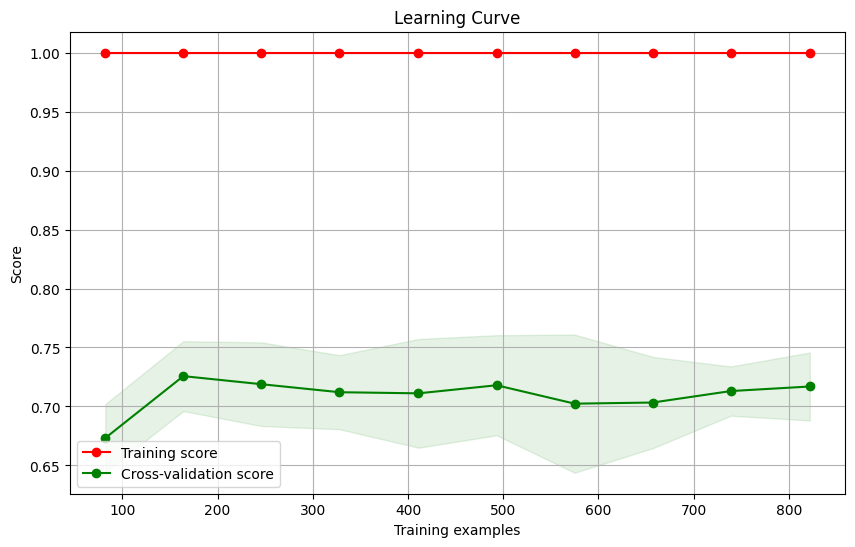

In [27]:
import xgboost as xgb

clf = xgb.XGBClassifier()

plot_learning_curve(clf, X_train, y_train)

In [29]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

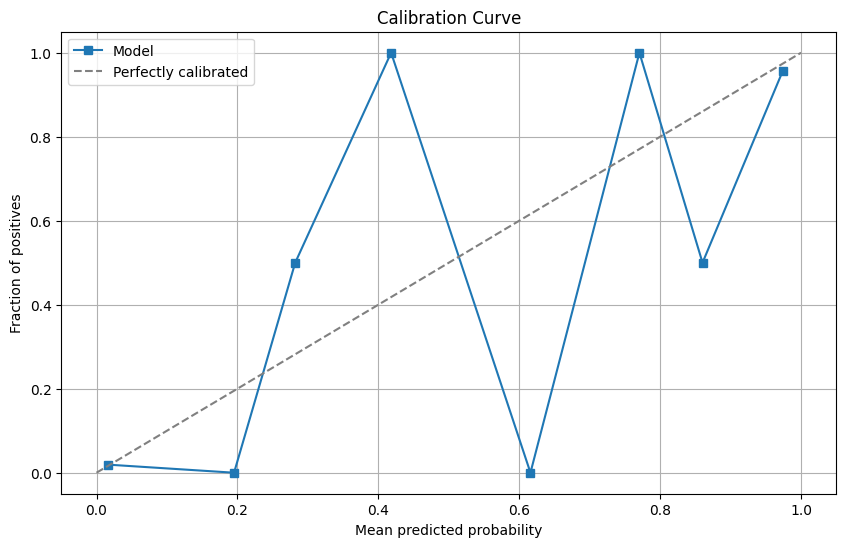

In [30]:
plot_calibration_curve(clf, X_test, y_test)

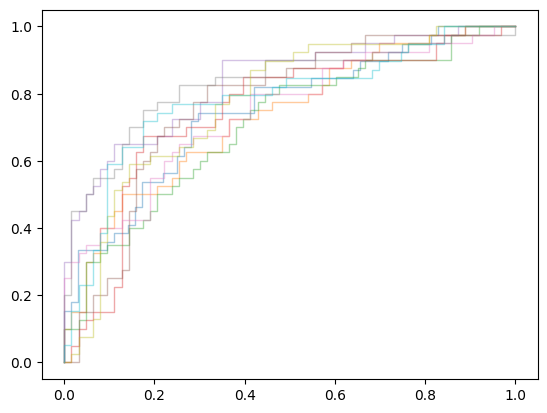

In [38]:
from sklearn import clone
from sklearn.model_selection import StratifiedKFold

best_auc = 0.0
tprs_train, tprs_valid = [], []
fpr_train_alls, tpr_train_alls = [], []
mean_fpr = np.linspace(0, 1, 100)
KF = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
for i, (train_index, valid_index) in enumerate(KF.split(X_train, y_train)):
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
    Y_train_kf, Y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = clone(clf).fit(X_train_kf, Y_train_kf)

    fpr_train, tpr_train, metric_dic_train, _ = classification_metric_evaluate(
        model, X_train_kf, Y_train_kf,
    )
    fpr_valid, tpr_valid, metric_dic_valid, _ = classification_metric_evaluate(
        model, X_valid_kf, Y_valid_kf, Threshold=metric_dic_train["cutoff"]
    )
    metric_dic_valid.update({"cutoff": metric_dic_train["cutoff"]})

    if metric_dic_valid["AUC"] > best_auc:
        clf = model
        resThreshold = metric_dic_train["cutoff"]

    tprs_valid.append(np.interp(mean_fpr, fpr_valid, tpr_valid))
    tprs_valid[-1][0] = 0.0

    # To draw a picture, you only need plt.plot(fpr,tpr). The variable roc_auc just records the value of auc and calculates it through the auc() function.
    validationCurve =True
    if validationCurve:
        plt.plot(
            fpr_valid, tpr_valid,
            lw=1, alpha=0.4,
            label='ROC fold %4d (auc=%0.3f 95%%CI (%0.3f-%0.3f))' % (
            i + 1, metric_dic_valid['AUC'], metric_dic_valid['AUC_L'], metric_dic_valid['AUC_U']),
        )

    ##Training set ROC
    fpr_train_alls.append(fpr_train)
    tpr_train_alls.append(tpr_train)
    tprs_train.append(np.interp(mean_fpr, fpr_train, tpr_train))
    tprs_train[-1][0] = 0.0

# Cross-val with XGBoost

In [11]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb


# Define parameters for XGBoost
params = {
    # "max_depth": 9,  # maximum depth of the tree
    # "colsample_bylevel": 1.0,
    # "colsample_bynode": 0.0,
    # "colsample_bytree": 0.23111437122462683,
    # "gamma": 0.0,
    # "learning_rate": 0.05,
    # "n_estimators": 1000,  # Set the number of boosting rounds
}

classifier = xgb.XGBClassifier(**params)

cv_scores = cross_val_score(classifier, X, y, cv=10, scoring="recall")


# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean accuracy:", mean_accuracy)

Cross-validation scores: [0.53191489 0.70212766 0.59574468 0.59574468 0.375      0.6875
 0.52083333 0.60416667 0.58333333 0.5625    ]
Mean accuracy: 0.575886524822695


In [8]:
predictions = classifier.predict(X_test)
predictions

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0])

In [9]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report


accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print(classification_report(y_test, predictions))

Accuracy: 0.6868131868131868
              precision    recall  f1-score   support

       False       0.73      0.77      0.75       110
        True       0.62      0.56      0.58        72

    accuracy                           0.69       182
   macro avg       0.67      0.66      0.67       182
weighted avg       0.68      0.69      0.68       182



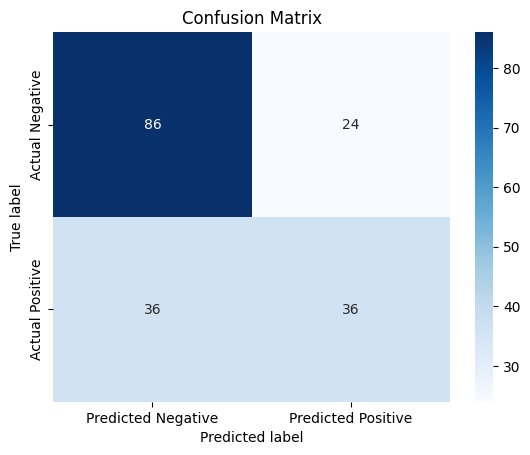

In [17]:
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test, predictions)

# Plot confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Negative", "Predicted Positive"],
    yticklabels=["Actual Negative", "Actual Positive"],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

# Hyperparams tune

In [18]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score


# Define your XGBoost model
model = XGBClassifier()

# Define the parameter grid to search through
param_grid = {
    "max_depth": [8, 9, 10],  # Maximum tree depth
    "learning_rate": [0.1, 0.05, 0.01],  # Learning rate
    "n_estimators": [500, 800, 100],  # Number of trees
}

# Define a custom scoring function to optimize for minimizing false negatives
scorer = make_scorer(recall_score, pos_label=1)

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid,
    # scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 500}

In [14]:
# Train the model with the best parameters
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)

F1 Score: 0.5454545454545454


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.70      0.78      0.74       110
        True       0.60      0.50      0.55        72

    accuracy                           0.67       182
   macro avg       0.65      0.64      0.64       182
weighted avg       0.66      0.67      0.66       182



# LassoCV

In [16]:
from sklearn.linear_model import LassoCV
import pandas as pd

# Feature selection using LassoCV
lasso_cv = LassoCV(cv=5, random_state=7)
lasso_cv.fit(X, y)
selected_features = X.columns[lasso_cv.coef_ != 0]

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame({"column_name": X.columns, "lasso_coef": lasso_cv.coef_}).T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
column_name,macroangiopathy,microangiopathy,age,weight,mechanical_ventilation,use_crrt,use_NaHCO3,wbc,hb,plt,ag,bicarbonate,bun,calcium,scr,bg,phosphate,egfr,gcs,oasis,sofa,saps2,hr,rr,sbp,dbp,preiculos,history_aci,history_ami,congestive_heart_failure,malignant_cancer,hypertension,uti,chronic_pulmonary_disease,dka_type_0,dka_type_1,dka_type_2,gender_F,gender_M,race_AMERICAN INDIAN/ALASKA NATIVE,race_ASIAN,race_ASIAN - CHINESE,race_ASIAN - SOUTH EAST ASIAN,race_BLACK/AFRICAN,race_BLACK/AFRICAN AMERICAN,race_BLACK/CAPE VERDEAN,race_BLACK/CARIBBEAN ISLAND,race_HISPANIC OR LATINO,race_HISPANIC/LATINO - CUBAN,race_HISPANIC/LATINO - DOMINICAN,race_HISPANIC/LATINO - GUATEMALAN,race_HISPANIC/LATINO - MEXICAN,race_HISPANIC/LATINO - PUERTO RICAN,race_HISPANIC/LATINO - SALVADORAN,race_MULTIPLE RACE/ETHNICITY,race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,race_OTHER,race_PORTUGUESE,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,liver_disease_MILD,liver_disease_NONE,liver_disease_SEVERE,ckd_stage_0.0,ckd_stage_1.0,ckd_stage_2.0,ckd_stage_3.0,ckd_stage_4.0
lasso_coef,0.0,0.0,0.003032,0.004326,-0.0,-0.0,-0.0,-0.000319,-0.014703,0.00015,-0.0044,-0.0,-0.000047,-0.0,0.0,0.000142,0.005559,0.0,0.009143,0.011281,0.013751,0.005147,-0.001309,0.0,-0.000636,0.001158,0.000309,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0


In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


# Splitting data into training and validation cohorts
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "XGBClassifier": XGBClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LGBMClassifier": LGBMClassifier(),
    "SVC": SVC(),
    "MLPClassifier": MLPClassifier(),
    "GaussianNB": GaussianNB(),
    "ComplementNB": ComplementNB(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "BaggingClassifier": BaggingClassifier(),
}

# Perform cross-validation and evaluate each model
results = {}
for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, X, y, cv=10)
    results[clf_name] = scores.mean()

# Print results
for clf_name, score in results.items():
    print(f"{clf_name}: {score}")

/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also re

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 429, number of negative: 660
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 1089, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393939 -> initscore=-0.430783
[LightGBM] [Info] Start training from score -0.430783
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 429, number of negative: 660
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2520
[LightGBM] [Info] Number of data points in the train set: 1089, number of used features:

/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/data3/users/tubh/PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/media/data3/users/tubh/PredictingRis

LogisticRegression: 0.7479338842975206
XGBClassifier: 0.7132231404958678
RandomForestClassifier: 0.7446280991735538
LGBMClassifier: 0.7198347107438017
SVC: 0.7057851239669423
MLPClassifier: 0.6818181818181819
GaussianNB: 0.703305785123967
ComplementNB: 0.6727272727272728
AdaBoostClassifier: 0.71900826446281
KNeighborsClassifier: 0.6396694214876033
DecisionTreeClassifier: 0.6495867768595042
BaggingClassifier: 0.7049586776859504


# Other

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
import xgboost as xgb

estimators = [
    ("encoder", TargetEncoder()),
    ("clf", xgb.XGBClassifier(random_state=8)),
]

pipe = Pipeline(steps=estimators, verbose=True)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))],
         verbose=True)

In [29]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


searchSpace = {
    "clf__max_depth": Integer(5, 11),
    "clf__learning_rate": Real(0.001, 1.0, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.0, 0.5),
    "clf__colsample_bylevel": Real(0.5, 1.0),
    "clf__colsample_bynode": Real(0.0, 0.5),
    "clf__reg_alpha": Real(0.0, 10.0),
    "clf__reg_lambda": Real(0.0, 10.0),
    "clf__gamma": Real(0.0, 10.0),
}

opt = BayesSearchCV(
    pipe, search_spaces=searchSpace, cv=3, n_iter=50, scoring="roc_auc", random_state=7
)

opt.fit(X, y)

[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.4s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.6s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.8s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.0s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.7s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.0s
[Pipeline] ........... (step 1 of 2) Processing encoder, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipel

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=5, high=11, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [32]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=1.0, colsample_bynode=0.0,
                               colsample_bytree=0.23111437122462683,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.009133880104785132, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=11,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=8, ...))],
         verbose=True)

In [30]:
opt.best_score_

0.7708508940072679

In [31]:
opt.score(X_test, y_test)

0.8683080808080809

In [ ]:
opt.best_estimator_.steps